## Part 2: 

Badly performing dataset:

On the previous example, the initital performance of classification algorithms were very high. Feature engeneering managed to marginally  improve the accuracy of the model(probably not significant). The Wine dataset present a more challenging issue. It is known for having relatively low accuracy mainly due to how imbalanced its clasess are.

Whatis intended to be answered in this second part is how different feature engeneering techniques can improve (if possible) a relatively badly performing dataset. 

Dataset available at: https://www.kaggle.com/rajyellow46/wine-quality


In [1]:
from yellowbrick.model_selection import FeatureImportances
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from yellowbrick.features import rank2d
from yellowbrick.classifier import ClassificationReport
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from sklearn.feature_selection import RFE
import pickle
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import BernoulliRBM
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold


In [2]:
#import plotly.graph_objects as go
#import plotly.express as px

In [3]:
# Changing pandas display options:
pd.set_option('max_columns',50) 

## 1. Importing Data:

In [4]:
Wine_Quality = pd.read_csv('winequalityN.csv', sep = ',')

## 2. Eploratory data analysis

In [5]:
# taking a glimpse of the data.
Wine_Quality.head(5)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [6]:
Wine_Quality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [7]:
# Consulted:

# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html
# https://www.geeksforgeeks.org/python-pandas-isnull-and-notnull/
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html
# https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html

<AxesSubplot:>

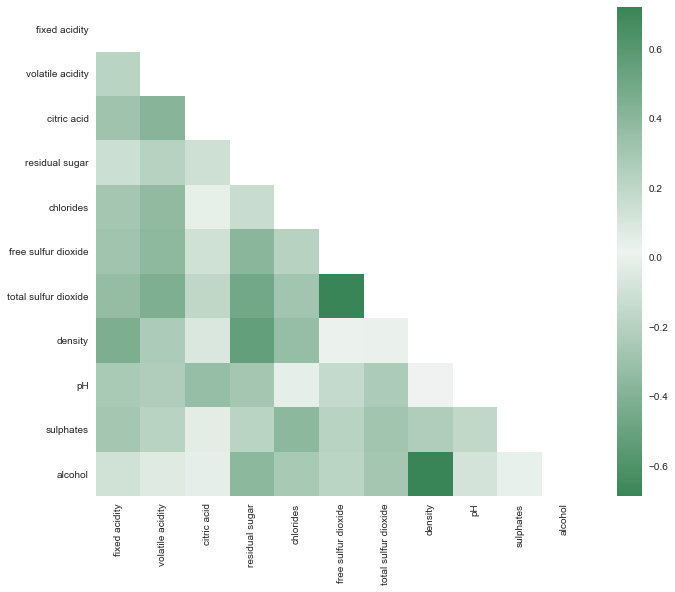

In [8]:
# Creating a pairplot to visualize the continuous features.
# Identifiying highly correlated features. Altough not dealing with multiple regression,it is good to keep things as simple as 
# possible

# consulted: https://towardsdatascience.com/the-curse-of-dimensionality-50dc6e49aa1e

# Introduction to statistical learning

Wine_data_continuous = Wine_Quality.drop(columns = ['quality'])

corr = Wine_data_continuous.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(500, 500, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap = cmap)
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html


Correlation is not extremely strong. Ony density/alcohol seems to be closer to .8

## 3. Data Preprocessing:

In [9]:
# Dealing with possible missing values and duplicates\

Wine_Quality.drop_duplicates(inplace = True)

nan = float("NaN") 
Wine_Quality.replace("", nan, inplace=True) # blank values present?


# source:  https://www.kite.com/python/answers/how-to-drop-empty-rows-from-a-pandas-dataframe-in-python

Wine_Quality.dropna(inplace = True)
print(f'No NaNs?:  {all(Wine_Quality.notnull())}\n') 


No NaNs?:  True



## 3. Model Selection

This time, To keep things simple. Only Random Forest Classifier will be used.


In [10]:
Accuracies = {} # creating an accuracy dictionary for the plot afterwards

y = Wine_Quality.iloc[:,[-1]]
X = Wine_Quality.iloc[:,0:-2]


In [11]:
Types = pd.get_dummies(Wine_Quality['type'])

X = pd.concat([X, Types], axis = 1).reset_index()
X = X.drop(['type', 'index'], axis = 1)
# https://pandas.pydata.org/docs/reference/api/pandas.concat.html
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html

## 3.1 Preliminary model results and Feature Improvement

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=165)

y_train = np.ravel(y_train)

In [13]:
def forest_plot(X_train, X_test, technique, min_samples_split = 190):
    
    n_estimators = [i for i in range(100,260,20)]
    accuracy = []

    for n in n_estimators:
        tree = RandomForestClassifier(n_estimators = n , min_samples_split = 190, random_state = 11) # to reduce 
        tree.fit(X_train, y_train)
        y_predict = tree.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_predict)*100)
    
    # good source for matplotlib parameters: https://matplotlib.org/3.1.1/api/pyplot_summary.html
    plt.plot(n_estimators, accuracy, linestyle ='dashed', marker = 'o', color = 'blue') # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html
    plt.xticks(n_estimators)
    plt.title('Accuracies vs samples')
    plt.xlabel('number of trees')
    plt.ylabel('Accuracy (in percentage)')

    plt.show()
    
    print(f'List of accuracies:\n{np.around(accuracy, 3)}\n') #https://www.kite.com/python/docs/numpy.around
    print(f'Optimal Accuracy:\n{round(max(accuracy),3)}')
    Accuracies[technique] = max(accuracy)

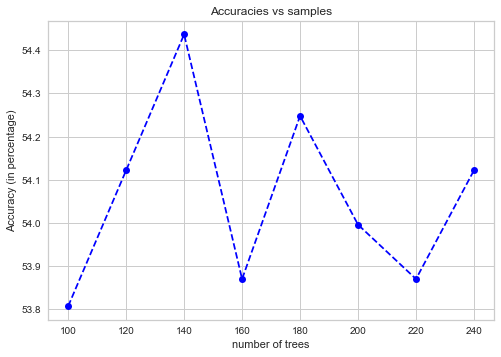

List of accuracies:
[53.807 54.122 54.437 53.87  54.248 53.996 53.87  54.122]

Optimal Accuracy:
54.437


In [14]:
forest_plot(X_train, X_test, 'Without Class Reassign')

The optimal minimal number of Trees is: 140

This dataset is relatively well known, and its accuracy could be improved by reassigning labels on the dataset. Instead of performing resampling as a way to deal with class imbalance, the classes will be reduced to 3 levels. 

Online examples like the one here: 
https://www.kaggle.com/ckoushik2805/winequality-classification-model-95-accuracy  

This example managed to greatly improve accuracy by reducing the labels to only three. The objective of this second part was to use all the studied feature engineering techniques in order to further improve the model



## 4. Reassigning Labels

In [15]:
Wine_Quality.groupby('quality').count()

# there is significant class inmbalance in this dataset. Atempting oversampling:

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
quality,,,,,,,,,,,,
3,30,30,30,30,30,30,30,30,30,30,30,30
4,204,204,204,204,204,204,204,204,204,204,204,204
5,1745,1745,1745,1745,1745,1745,1745,1745,1745,1745,1745,1745
6,2311,2311,2311,2311,2311,2311,2311,2311,2311,2311,2311,2311
7,852,852,852,852,852,852,852,852,852,852,852,852
8,148,148,148,148,148,148,148,148,148,148,148,148
9,5,5,5,5,5,5,5,5,5,5,5,5


In [16]:
y.value_counts()

quality
6          2311
5          1745
7           852
4           204
8           148
3            30
9             5
dtype: int64

In [17]:
# Reasinging labels:
new_y = y.values
for i in range(0, len(new_y)):
    if new_y[i] == 3 or new_y[i] == 4:
        new_y[i] = 0
    elif new_y[i] == 5 or new_y[i] == 6:
        new_y[i] = 1
    elif new_y[i] == 7 or new_y[i] == 8 or new_y[i] == 9:
        new_y[i] = 2
        
# consulted: https://www.kaggle.com/ckoushik2805/winequality-classification-model-95-accuracy

In [18]:
new_y = pd.DataFrame(new_y)

In [19]:
new_y.value_counts()

1    4056
2    1005
0     234
dtype: int64

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,new_y, test_size=0.30, random_state=163)

y_train = np.ravel(y_train)

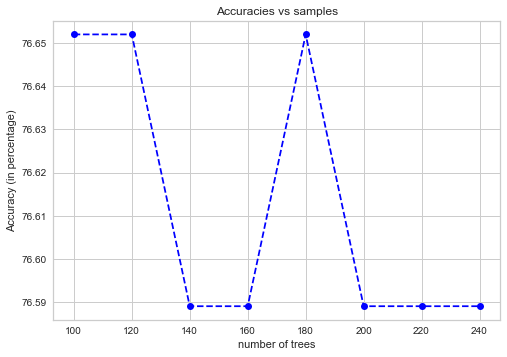

List of accuracies:
[76.652 76.652 76.589 76.589 76.652 76.589 76.589 76.589]

Optimal Accuracy:
76.652


In [21]:
forest_plot(X_train, X_test, 'Class Reassign', min_samples_split = 190)

In this case, the optimal number of trees was 120

## 5 Feature Selection

In [22]:
# Only doing feature importances:

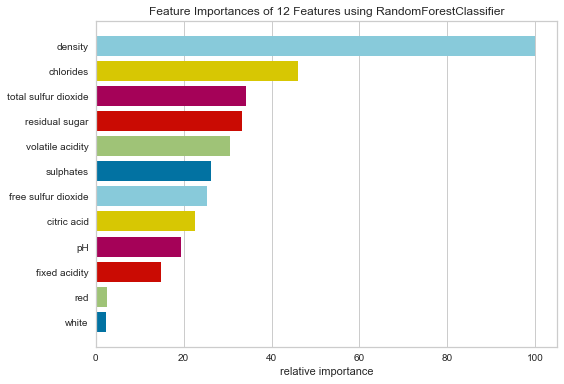

<AxesSubplot:title={'center':'Feature Importances of 12 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [23]:
model = RandomForestClassifier(n_estimators = 160 , min_samples_split = 190, random_state = 12)
importances = FeatureImportances(model)
importances.fit(X_train, y_train)
importances.show()
# https://www.scikit-yb.org/en/latest/api/model_selection/importances.html

### Recursive Feature Elimination:

This technique will try the performance of the algorithm by resursively trying all the features. After the optimal number of features is found, the most important features will be selected and recursively tested. Features with no importance are not considered in the recursive test.

In [24]:
def recfe(target, data, algorithm):

    classifier = algorithm
    rfe = RFE(estimator=classifier, n_features_to_select= 1, step=1, verbose = 10)
    rfe.fit(data,target)
    optimal_features = rfe.ranking_

    print(f"Optimal number of features : {optimal_features[0]}") 

In [25]:
def recfecv(target, data, algorithm):
    
    classifier = algorithm
    rfecv = RFECV(estimator=classifier, step=1, cv=KFold(12), scoring='accuracy', verbose = 10, n_jobs = -1)
    rfecv.fit(data,target)
    optimal_features = rfecv.n_features_

    print("Optimal number of features with Cross Validation is : %d" % rfecv.n_features_) 
    
    
    plt.figure()
    plt.title('Recursive Feature Elimination with 12 fold cross validation')
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, linestyle ='dashed', marker = 'o', color = 'blue')
    plt.show()
  # https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html      

In [26]:
recfe(y_train,X_train, RandomForestClassifier(n_estimators = 120 , min_samples_split = 190, random_state = 13))

Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Optimal number of features : 10


Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Optimal number of features with Cross Validation is : 9


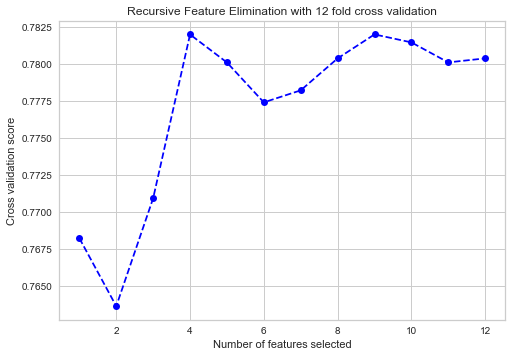

In [27]:
recfecv(y_train,X_train, RandomForestClassifier(n_estimators = 120 , min_samples_split = 190, random_state = 14))

In [28]:
X_train.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'red', 'white'],
      dtype='object')

##### Selecting the 9 best features (after performing recursive feature elimination with 12 fold cross-validation):

In [29]:
X_train_recf = X_train.drop(columns = ['fixed acidity', 'red', 'white'])
X_test_recf = X_test.drop(columns = ['fixed acidity', 'red', 'white'])

In [30]:
#### Running the model again without the meaninless features 

In [31]:
tree = RandomForestClassifier(n_estimators = 120 , min_samples_split = 190, random_state = 15) 
tree.fit(X_train_recf, y_train)
y_predict = tree.predict(X_test_recf)
accuracy = round(accuracy_score(y_test, y_predict)*100, 3)
print(f'Accuracy after recursive feature elimination: {accuracy}%')
Accuracies['RECFE'] = accuracy

Accuracy after recursive feature elimination: 77.03%


## 6. Feature construction:

#### Using Polynomial Features

In [32]:
# Note, This process will not be done in a loop doe to the time it takes to work with 3 and 4 degree polynomial
poly2 = PolynomialFeatures(2)
poly3 = PolynomialFeatures(3)
poly4 = PolynomialFeatures(4)

In [33]:
# working with polynomial features degree 2
X_train_poly2 = poly2.fit_transform(X_train_recf)
X_test_poly2 = poly2.transform(X_test_recf)

# working with polynomial features degree 3
X_train_poly3 = poly3.fit_transform(X_train_recf)
X_test_poly3 = poly3.transform(X_test_recf)

# working with polynomial features degree 4
X_train_poly4 = poly4.fit_transform(X_train_recf)
X_test_poly4 = poly4.transform(X_test_recf)

In [34]:
clf = RandomForestClassifier(n_estimators = 160 , min_samples_split = 190, random_state = 16)
clf.fit(X_train_poly2, y_train)
y_predict = clf.predict(X_test_poly2)
accuracy_poly2 = round(accuracy_score(y_test, y_predict)*100,3)
print(f'Desicion Tree Accuracy after appliying polynomial feafures with degree 2 : {accuracy_poly2 } %') 
Accuracies['2 Degree Construction'] = accuracy_poly2

clf = RandomForestClassifier(n_estimators = 160 , min_samples_split = 190, random_state = 17)
clf.fit(X_train_poly3, y_train)
y_predict = clf.predict(X_test_poly3)
accuracy_poly3 = round(accuracy_score(y_test, y_predict)*100,3)
print(f'Desicion Tree Accuracy after appliying polynomial feafures with degree 3 : {accuracy_poly3 } %')
Accuracies['3 Degree Construction'] = accuracy_poly3

clf = RandomForestClassifier(n_estimators = 160 , min_samples_split = 190, random_state = 18)
clf.fit(X_train_poly4, y_train)
y_predict = clf.predict(X_test_poly4)
accuracy_poly4 = round(accuracy_score(y_test, y_predict)*100,3)
print(f'Desicion Tree Accuracy after appliying polynomial feafures with degree 4 : {accuracy_poly4 } %') 
Accuracies['4 Degree Construction'] = accuracy_poly4

Desicion Tree Accuracy after appliying polynomial feafures with degree 2 : 77.47 %
Desicion Tree Accuracy after appliying polynomial feafures with degree 3 : 77.155 %
Desicion Tree Accuracy after appliying polynomial feafures with degree 4 : 77.218 %


Surprisingly, here there was some improvement over the accuracy. The score went up from 77.03 to 77.47% when creating more features using 2th polynomial. 

## 7. Feature Transformation

#### Principal component analysis:

In [35]:
def pca_accuracies(ncomponents, X_train, X_test, y_train, y_test, algorithm):
    components = range(1,ncomponents+1)
    accuracy_pca = []
    for c in components:
        pca = PCA(n_components=c)
        pca.fit(X_train)
        X_train_pca = pca.transform(X_train) 
        X_test_pca = pca.transform(X_test)
        clf = algorithm
        clf.fit(X_train_pca, y_train)
        y_predict = clf.predict(X_test_pca)
        accuracy_pca.append(round(accuracy_score(y_test, y_predict)*100,3))

    plt.plot(components, accuracy_pca, linestyle ='dashed', marker = 'o', color = 'purple') 
    plt.xticks(components)
    plt.title('Number of components vs Accuracy')
    plt.xlabel('Number of Components')
    plt.ylabel('Accuracy (in percentage)')

    plt.show()

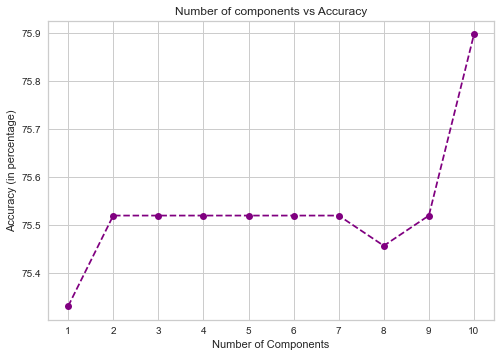

In [36]:
pca_accuracies(10,X_train, X_test, y_train, y_test, RandomForestClassifier(n_estimators = 120 , min_samples_split = 190, random_state = 19))

Optimal Number of components: 10

In [37]:
pca = PCA(n_components=10)
pca.fit(X_train)
X_train_pca = pca.transform(X_train) 
X_test_pca = pca.transform(X_test) 

#### Linear Discriminant Analysis:

In [38]:
def lda(x_train,x_test, y_train, y_test, algorithm):
    lda = LinearDiscriminantAnalysis(n_components=2)
    lda.fit(x_train, y_train)
    x_train = lda.transform(x_train) 
    x_test = lda.transform(x_test)
    tree = algorithm
    tree.fit(x_train, y_train)
    y_predict = tree.predict(x_test)
    accuracy_lda = round(accuracy_score(y_test, y_predict)*100,3)
    return accuracy_lda

In [39]:
# using linear discriminant analysis with results from one component PCA

print(f'Decision Tree Accuracy after using lda from from pca : {lda(X_train_pca,X_test_pca, y_train, y_test, RandomForestClassifier(n_estimators = 120 , min_samples_split = 190, random_state = 20))} %')
Accuracies['PCA\LDA'] = lda(X_train_pca,X_test_pca, y_train, y_test, RandomForestClassifier(n_estimators = 120 , min_samples_split = 190, random_state = 11))

Decision Tree Accuracy after using lda from from pca : 75.205 %


In [40]:
print(f'Decision Tree Accuracy after using lda from recursive feature elimination : {lda(X_train_recf,X_test_recf, y_train, y_test, RandomForestClassifier(n_estimators = 120 , min_samples_split = 190))} %') 
Accuracies['RECFE\LDA'] = lda(X_train_recf,X_test_recf, y_train, y_test, RandomForestClassifier(n_estimators = 120 , min_samples_split = 190, random_state = 21))

Decision Tree Accuracy after using lda from recursive feature elimination : 77.03 %


In [41]:
print(f'Decision Tree Accuracy after using lda from recursive feature elimination and second degree polynomial : {lda(X_train_recf,X_test_recf, y_train, y_test, RandomForestClassifier(n_estimators = 120 , min_samples_split = 190))} %') 
Accuracies['RECFE/LDA/Second Degree'] = lda(X_train_poly2,X_test_poly2, y_train, y_test, RandomForestClassifier(n_estimators = 120 , min_samples_split = 190, random_state = 30))

Decision Tree Accuracy after using lda from recursive feature elimination and second degree polynomial : 77.47 %


Accuracy managed to be very high when using linear discriminant analysis with recursive feature elimination but it was not the highest

## 8 Feature Learning:

The Technique that will be used here is Bernoulli Restricted Boltzmann Machine (RBM)

In [42]:
def rbm(x_train,x_test, y_train, y_test, algorithm, n_iter = 100, n_components = 256, learning_rate=0.5):
    rmb = BernoulliRBM(random_state = 10, n_iter = n_iter, n_components = n_components, learning_rate = learning_rate)
    rmb.fit(x_train)
    x_train_r = rmb.transform(x_train) 
    x_test_r = rmb.transform(x_test)
    clf = algorithm
    clf.fit(x_train_r, y_train)
    y_predict = clf.predict(x_test_r)
    accuracy_rbm = round(accuracy_score(y_test, y_predict)*100,3)
    print(f"Accurary for {algorithm}: {accuracy_rbm}") 
    return accuracy_rbm

# consulted: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.BernoulliRBM.html
# Feature engeneering made easy

In [43]:
# Using PCA Results:
rbm_pca = rbm(X_train_pca,X_test_pca, y_train, y_test,RandomForestClassifier(n_estimators = 120 , min_samples_split = 190, random_state = 22))
Accuracies['RBM\PCA'] = rbm_pca

Accurary for RandomForestClassifier(min_samples_split=190, n_estimators=120, random_state=22): 75.519


In [44]:
# Using Recursive Feature Elimination Results:
rbm_recv = rbm(X_train_recf,X_test_recf, y_train, y_test,RandomForestClassifier(n_estimators = 120 , min_samples_split = 190, random_state = 23))
Accuracies['RBM\RECFE'] = rbm_recv

Accurary for RandomForestClassifier(min_samples_split=190, n_estimators=120, random_state=23): 75.519


### Summary:
    
Overall accuracy managed to improve from 76.652% to 78.351% not including label reasingment. This improvement was only 1.7% but it was slightly higher than the increase in overall accuracy from the previous model. In both cases, recursive feature elimination proved to have the best overall performance across models.



In [45]:
def accuracy_ranking(techniques, accuracies, algorithm, color = "flare"):
    
    data = {'Techniques': techniques, 'Accuracies': accuracies}
    data_alg = pd.DataFrame(data = data)
    data_alg = round(data_alg.sort_values(by = ['Accuracies']),3)
    #plt.bar(data_knn['Techniques'],data_knn['Accuracies'], color = 'green' )
    
    ax = sns.barplot(x='Techniques', y='Accuracies', palette= color, data = data_alg)
    plt.title(f'Performance ranking of {algorithm} algorithm with different feature engineering techniques')
    plt.xticks(rotation = 90)
    plt.ylabel('Accuracies After Class Reassing(percentage)')
    plt.xlabel('Techniques')
    plt.ylim([0,80])
    plt.show()
    return data_alg
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html
# https://stackabuse.com/rotate-axis-labels-in-matplotlib/
# https://stackabuse.com/how-to-set-axis-range-xlim-ylim-in-matplotlib/
# https://stackoverflow.com/questions/53577630/how-to-make-pareto-chart-in-python
# https://www.geeksforgeeks.org/rotate-axis-tick-labels-in-seaborn-and-matplotlib/
# https://seaborn.pydata.org/generated/seaborn.barplot.html
# https://seaborn.pydata.org/generated/seaborn.color_palette.html

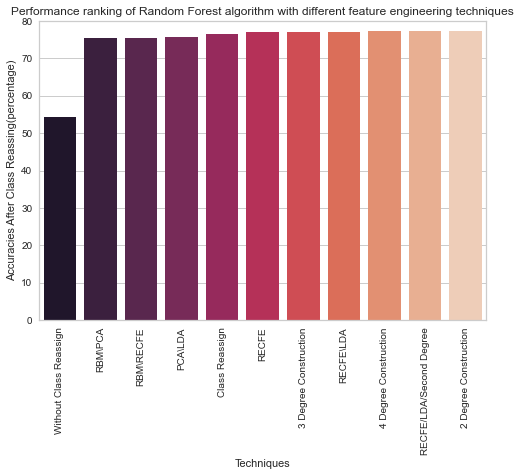

,Techniques,Accuracies
0,Without Class Reassign,54.437
9,RBM\PCA,75.519
10,RBM\RECFE,75.519
6,PCA\LDA,75.708
1,Class Reassign,76.652
2,RECFE,77.030
4,3 Degree Construction,77.155
7,RECFE\LDA,77.155
5,4 Degree Construction,77.218
8,RECFE/LDA/Second Degree,77.344


In [46]:
accuracy_ranking(list(Accuracies.keys()),list(Accuracies.values()), 'Random Forest', color = 'rocket')

In this example, the accuracy managed to improve a little more than for the Insurance Dataset. The improvement it is almost two points. This could seem slow and non-significant, but, random seed was different every time that a new feature engineering techniques was implemented.



## Additional References

https://www.kaggle.com/rajyellow46/wine-quality

https://matplotlib.org/3.1.1/api/pyplot_summary.html

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html

https://www.kite.com/python/docs/numpy.around

https://www.kaggle.com/ckoushik2805/winequality-classification-model-95-accuracy

